In [1]:
import os
import copy
import sys
import glob
sys.path.append('..')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchvision.models import resnet101, mobilenet_v2
from tqdm import tqdm

from utils.robust_optimizer import RobustOptimizer

print(f'Torch version: {torch.__version__}')
print(f'Timm version: {timm.__version__}')

Torch version: 2.3.0+cu121
Timm version: 0.9.16


# Training

## Configurations

In [2]:
dataset_dir = '..\\datasets\\raf\\basic'
backbone = 'efficientnet_b0'

In [3]:
batch_size = 32
epochs = 40
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [4]:
IMG_SIZE = 260 if 'b2' in backbone else 224

train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [5]:
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

## RAF-DB Dataloader

In [6]:
class RafDb(data.Dataset):
    def __init__(self, dataset_path, phase, cache_data=True, data_transforms=None, update_cache=False):
        self.phase = phase
        self.transforms = data_transforms
        self.dataset_path = dataset_path
        
        if cache_data:
            cache_path = os.path.join(dataset_path, f'rafdb_{phase}.csv')
            if os.path.exists(cache_path) and not update_cache:
                df = pd.read_csv(cache_path)
            else:
                df = self.load_data()
                df.to_csv(cache_path)   
        else:
            df = self.load_data()

        if phase == 'train':
            self.data = df[df['file_name'].str.startswith('train')]
        elif phase == 'test':
            self.data = df[df['file_name'].str.startswith('test')]
        else:
            raise TypeError(f"Invalid value for phase {phase}")
        
        self.file_paths = self.data.loc[:, 'file_path'].values
        self.labels = self.data.loc[:, 'label'].values - 1
        print(f'{phase} set: {len(self)} images')
            
    def load_data(self):
        df = pd.read_csv(os.path.join(self.dataset_path, 'EmoLabel', 'list_patition_label.txt'), sep=' ', header=None, names=['file_name', 'label'])
        file_names = df.loc[:, 'file_name'].values
        file_paths = []
        for f in file_names:
            f = f.split(".")[0]
            f += '_aligned.jpg'
            path = os.path.join(self.dataset_path, 'Image', 'aligned', f)
            file_paths.append(path)
        
        df['file_path'] = file_paths
        return df
    
    def get_weights(self):
        sample_label, sample_counts = np.unique(self.labels, return_counts=True)
        cw = 1/sample_counts
        cw /= cw.min()
        class_weights = {i:cwi for i, cwi in zip(sample_label, cw)}
        return class_weights
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.labels[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label

In [7]:
class EmotionLabel:
    def __init__(self):
        self.labels = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
        self.index_to_label = {index: label for index, label in enumerate(self.labels)} 
        self.label_to_index = {label: index for index, label in enumerate(self.labels)}
        
    def get_index(self, label):
        return self.label_to_index.get(label, None)
    
    def get_label(self, index):
        return self.index_to_label.get(index, None)

In [8]:
train_set = RafDb(dataset_dir, 'train', data_transforms=train_transforms, update_cache=False)
val_set = RafDb(dataset_dir, 'test', data_transforms=test_transforms, update_cache=False)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, **kwargs)

train set: 12271 images
test set: 3068 images


In [9]:
mapper = EmotionLabel()

class_weights = train_set.get_weights()
for label_idx, weight in class_weights.items():
    print(f'{mapper.get_label(label_idx)}: {weight:.2f}')

Surprise: 3.70
Fear: 16.98
Disgust: 6.66
Happiness: 1.00
Sadness: 2.41
Anger: 6.77
Neutral: 1.89


# Functions

In [10]:
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [11]:
weights = torch.FloatTensor(list(class_weights.values())).cuda()

def label_smooth(target, n_classes: int, label_smoothing=0.1):
    # One-hot encoding
    batch_size = target.size(0)
    target = torch.unsqueeze(target, 1)
    soft_target = torch.zeros((batch_size, n_classes), device=target.device)
    soft_target.scatter_(1, target, 1)
    # Label smoothing
    soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
    return soft_target

def cross_entropy_loss_with_soft_target(pred, soft_target):
    return torch.mean(torch.sum(-weights * soft_target * torch.log(pred), 1))

def cross_entropy_with_label_smoothing(pred, target):
    soft_target = label_smooth(target, pred.size(1))
    return cross_entropy_loss_with_soft_target(pred, soft_target)

criterion = cross_entropy_with_label_smoothing

In [12]:
def train(model, n_epochs=epochs, learning_rate=lr, robust=False):
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learning_rate)
    else:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)        
        
    # scheduler
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    
    best_acc = 0
    best_model = None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_acc = 0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            if robust:
                # optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
                # second forward-backward pass
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            acc = (output.argmax(dim=1) == label).float().sum()
            epoch_acc += acc
            epoch_loss += loss
        epoch_acc /= len(train_set)
        epoch_loss /= len(train_set)
        
        model.eval()
        with torch.no_grad():
            epoch_val_acc = 0
            epoch_val_loss = 0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output, label)
                
                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_acc += acc
                epoch_val_loss += loss
        epoch_val_acc /= len(val_set)
        epoch_val_loss /= len(val_set)
        
        print(f"Epoch: {epoch + 1} - loss: {epoch_loss:.4f} - acc: {epoch_acc: .4f} - val_loss: {epoch_val_loss: .4f} - val_acc: {epoch_val_acc: .4f}\n")
        
        if best_acc < epoch_val_acc:
            best_acc = epoch_val_acc
            best_model = copy.deepcopy(model.state_dict())
        # scheduler.step()
        
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best accuracy: {best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_acc = 0
            epoch_val_loss = 0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output, label)
                
                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_acc += acc
                epoch_val_loss += val_loss
        epoch_val_acc /= len(val_set)
        epoch_val_loss /= len(val_set)
        
        print(f"val_loss: {epoch_val_loss: .4f} - val_acc: {epoch_val_acc: .4f}\n")
    else:
        print(f"No best model. Best accuracy so far: {best_acc}")

# Training

In [13]:
model = timm.create_model('tf_efficientnet_b0.ns_jft_in1k', pretrained=False)
model.classifier = torch.nn.Identity()
model.load_state_dict(torch.load('../models/pretrained_faces/vggface2_enet0.pt'))

<All keys matched successfully>

In [14]:
num_classes = len(mapper.labels)
# model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=num_classes)) #1792 #1280 #1536
model.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=num_classes),
    nn.Softmax(dim=1),
)
# model.head.fc=nn.Linear(in_features=3072, out_features=num_classes)
# model.head=nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
model = model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [15]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.classifier, requires_grad=True)
train(model, 3, 0.001, robust=True)

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [02:00<00:00,  3.19it/s]


Epoch: 1 - loss: 0.1675 - acc:  0.5401 - val_loss:  0.2259 - val_acc:  0.6760



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [01:18<00:00,  4.90it/s]


Epoch: 2 - loss: 0.1565 - acc:  0.6764 - val_loss:  0.1691 - val_acc:  0.7050



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [02:04<00:00,  3.09it/s]


Epoch: 3 - loss: 0.1538 - acc:  0.7012 - val_loss:  0.2082 - val_acc:  0.7647

Best accuracy: 0.7646675109863281
val_loss:  0.1491 - val_acc:  0.7647



In [15]:
set_parameter_requires_grad(model, requires_grad=True)
train(model, 6, 1e-4, robust=True)

100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [05:46<00:00,  1.11it/s]


Epoch: 1 - loss: 0.1469 - acc:  0.4969 - val_loss:  0.1197 - val_acc:  0.7503



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [05:51<00:00,  1.09it/s]


Epoch: 2 - loss: 0.1136 - acc:  0.7191 - val_loss:  0.0798 - val_acc:  0.7803



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [05:52<00:00,  1.09it/s]


Epoch: 3 - loss: 0.1022 - acc:  0.7792 - val_loss:  0.1188 - val_acc:  0.8439



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [05:52<00:00,  1.09it/s]


Epoch: 4 - loss: 0.0947 - acc:  0.8192 - val_loss:  0.0953 - val_acc:  0.8269



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [05:52<00:00,  1.09it/s]


Epoch: 5 - loss: 0.0881 - acc:  0.8569 - val_loss:  0.1114 - val_acc:  0.8282



100%|████████████████████████████████████████████████████████████████████████████████| 384/384 [05:51<00:00,  1.09it/s]


Epoch: 6 - loss: 0.0830 - acc:  0.8830 - val_loss:  0.0974 - val_acc:  0.8478

Best accuracy: 0.8477835655212402
val_loss:  0.0947 - val_acc:  0.8478



In [ ]:
# best 6 epochs: 0.8416 - 0.1003
# best 3 epochs: 0.7093 - 0.1146
# with robust best 6 epochs: 0.8634 - 0.0949

In [16]:
PATH = f'../models/raf/{backbone}_robust_softmax.pt'

In [17]:
torch.save(model, PATH)

In [18]:
print(PATH)
model = torch.load(PATH)
model = model.eval()

../models/raf/efficientnet_b0_robust_softmax.pt


In [19]:
y_val, y_scores_val = [], []
model.eval()

for image, label in val_set:
    image.unsqueeze_(0)
    image = image.cuda()
    scores = model(image)
    scores = scores[0].data.cpu().numpy()
    y_scores_val.append(scores)
    y_val.append(label)

y_scores_val = np.array(y_scores_val)
y_val = np.array(y_val)
print(y_scores_val.shape, y_val.shape)

(3068, 7) (3068,)


In [20]:
y_pred = np.argmax(y_scores_val, axis=1)
accuracy = 100.0 * (y_val == y_pred).sum() / len(y_val)
print(accuracy)

y_train = np.array(train_set.labels)

for i in range(y_scores_val.shape[1]):
    _val_acc = (y_pred[y_val == i] == i).sum() / (y_val == i).sum()
    print('%s (%d/%d) -- Accuracy: %f' %(mapper.get_label(i), (y_train == i).sum(), (y_val == i).sum(), (100 * _val_acc)))

84.77835723598436
Surprise (1290/329) -- Accuracy: 83.586626
Fear (281/74) -- Accuracy: 77.027027
Disgust (717/160) -- Accuracy: 86.250000
Happiness (4772/1185) -- Accuracy: 85.991561
Sadness (1982/478) -- Accuracy: 84.309623
Anger (705/162) -- Accuracy: 85.185185
Neutral (2524/680) -- Accuracy: 83.970588


In [21]:
labels = list(mapper.labels)
print(labels)
print(y_pred.shape, y_val.shape, (y_pred == y_val).mean())

['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral']
(3068,) (3068,) 0.8477835723598436


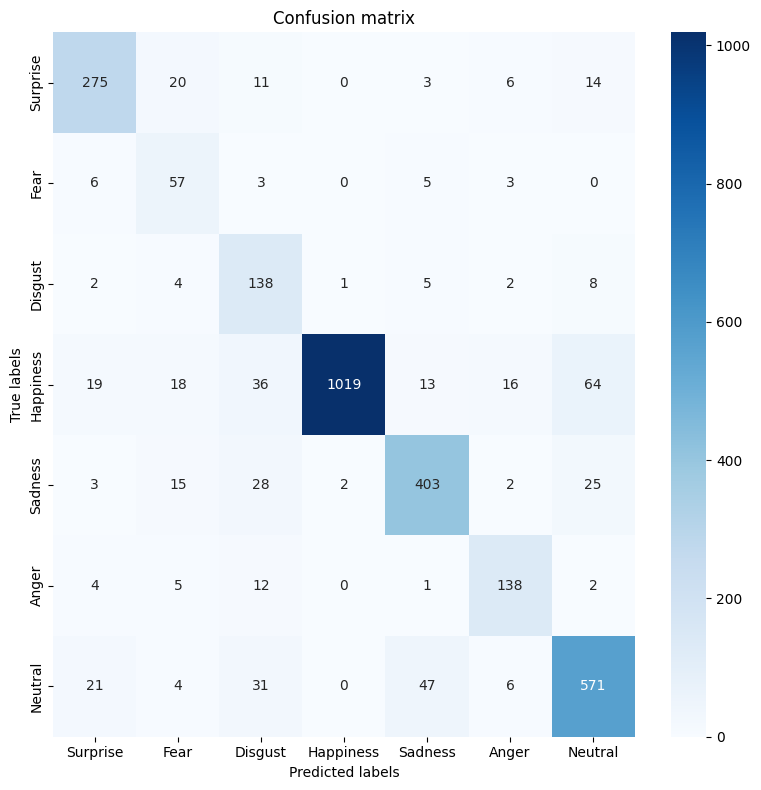

In [22]:
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.tight_layout()
plt.show()